In [95]:
 import sys
sys.path.insert(0, '../../../network')
sys.path.insert(0, '../../../figures')
from sequences import GaussianSequence
from transfer_functions import ErrorFunction
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from learning import ReachingTask
import pandas as pd

In [2]:
# Set font family globally
sns.set_style('white') 
colors = sns.color_palette('deep')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams['axes.linewidth'] = 0.1

### Filename and Directory

In [91]:
filename = 'learning-env-50-0.004-700-0.99-1-1'
path = '/work/jp464/striatum-sequence/' + filename + '.npz'
data = np.load(path) 
overlaps_ctx = data['overlaps_ctx']
overlaps_d1 = data['overlaps_d1']
# values = data['values']
# rpes = data['rpes']
# correlations_ctx = data['correlations_ctx']
# correlations_bg = data['correlations_bg']
# state_ctx = data['state_ctx']
# state_d1 = data['state_d1']

### Overlap vs Time

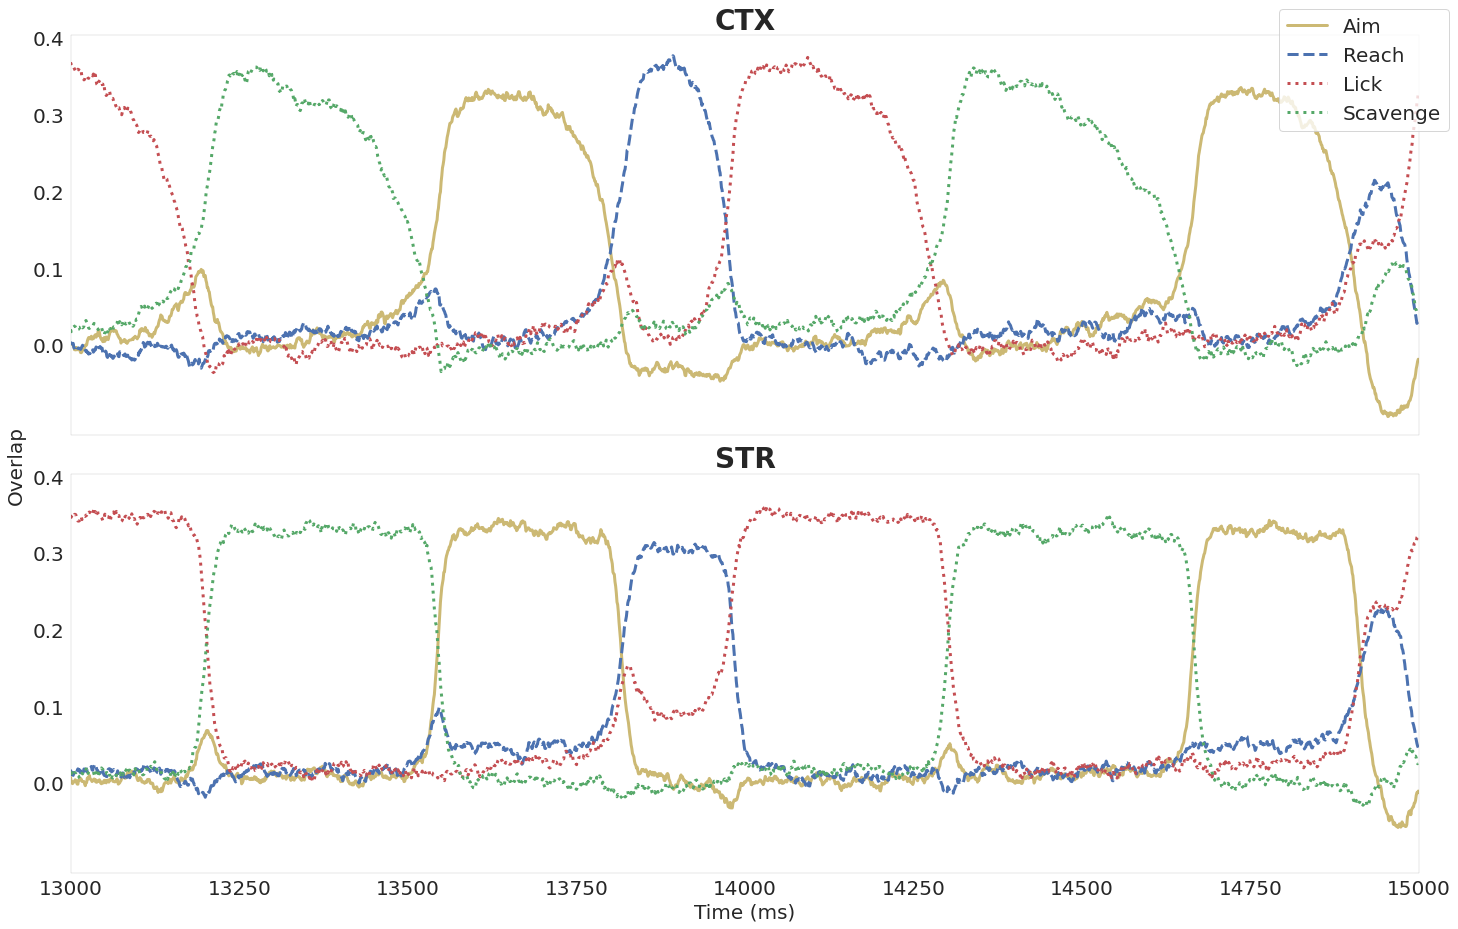

In [93]:
### Overlap 
fig, axes = plt.subplots(2,1, sharex=True, sharey=True, tight_layout=True, figsize=(20,13))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=3, color=colors[8])
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[0].plot(overlaps_ctx[3], linestyle='dotted', linewidth=3, color=colors[2])
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=28, weight='bold')
axes[1].plot(overlaps_d1[0], linestyle='solid', linewidth=3, color=colors[8])
axes[1].plot(overlaps_d1[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[1].plot(overlaps_d1[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[1].plot(overlaps_d1[3], linestyle='dotted', linewidth=3, color=colors[2])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("STR", fontsize=28, weight='bold')
axes[1].set_xlabel('Time (ms)', fontsize=20)
fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(13000, 15000))
plt.figlegend(labels=['Aim', 'Reach', 'Lick', 'Scavenge'], fontsize=20)
plt.savefig('/work/jp464/striatum-sequence/output/rpe-problem.jpg', bbox_inches = "tight", format='jpg')
# plt.show()



### Raster Plot

### Learning rate

### Phase diagram

In [98]:
df = pd.read_hdf('/work/jp464/striatum-sequence/output/retrieval_speed.h5', 'data')

In [ ]:
def compute(x, y, z, df):
    target = df.loc[(df['Abc']==x) & (df['Acb']==y) & (df['Abb']==z)]
    if len(target) == 0:
        return -1 
    return target.iloc[0, -2], target.iloc[0, -1]

def infer(x, y, z, df):
    seq, att = 0, 0
    for i in np.arange(-.4, .4, .1):
        for j in np.arange(-.4, .4, .1):
            score = compute(round(x+i,1), y, round(z+i,1), df)
            if score != -1:
                seq += score[0]
                att += score[1]
    if seq == 0 and att == 0:
        return 0
    elif seq >= att:
        return 10 
    else:
        return 5
    
def compute_score(x, y, z, df):
    x, y, z = round(x, 1), round(y, 1), round(z, 1)
    if x < 3 or z < 2 or y < 0.5:
        return 0
    target = df.loc[(df['Abc']==x) & (df['Acb']==y) & (df['Abb']==z)]
    cnt = 0
    while len(target) == 0:
        if cnt > 10:
            z += 0.1
        else: z -= 0.1
        z = round(z,1)
        target = df.loc[(df['Abc']==x) & (df['Acb']==y) & (df['Abb']==z)]
        cnt += 1
    if cnt > 30:
        print(cnt)
    return infer(x,y,z,df)


In [ ]:
Nx, Ny, Nz =np.arange(0, 6.1, 0.1), np.arange(0, 6.1, 0.5), np.arange(0, 6.1, 0.1)
X, Y, Z = np.meshgrid(Nx, Ny, Nz)
data = np.zeros(X.shape)
ax1, ax2, ax3 = X.shape
for i in trange(ax1):
    for j in range(ax2):
        for k in range(ax3):
            data[i][j][k] = compute_score(X[i][j][k],Y[i][j][k],Z[i][j][k], df)

In [ ]:
slice = 5
X1, Y1, Z1, data1 = X[slice:13,:,:], Y[slice:13,:,:], Z[slice:13,:,:], data[slice:13,:,:]
kw = {
    'vmin': data.min(),
    'vmax': data.max(),
    'levels': np.linspace(data.min(), data.max(), 10),
}


# Create a figure with 3D ax
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
_ = ax.contourf(
    X1[:, :, -1], Y1[:, :, -1], data1[:, :, -1],
    zdir='z', offset=Z1.max(), **kw
)
_ = ax.contourf(
    X1[0, :, :], data1[0, :, :], Z1[0, :, :],
    zdir='y', offset=Y1.min(), **kw
)
C = ax.contourf(
    data1[:, -1, :], Y1[:, -1, :], Z1[:, -1, :],
    zdir='x', offset=X1.max(), **kw
)

# Set limits of the plot from coord limits
xmin, xmax = X1.min(), X1.max()
ymin, ymax = Y1.min(), Y1.max()
zmin, zmax = Z1.min(), Z1.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# Plot edges
edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
# ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
# ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
# ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

# Set labels and zticks
ax.set(
    xlabel=r'$A_{bc}$',
    ylabel=r'$A_{cb}$',
    zlabel=r'$A_{cc} = A_{bb}$',
)

# Set zoom and angle view
ax.view_init(0, 280, 0)
# ax.view_init(40, -40, 0)
ax.set_box_aspect(None, zoom=0.9)

# Show Figure
plt.savefig('/work/jp464/striatum-sequence/output/phase-plane5.svg', bbox_inches = "tight", format='svg')

plt.show()